In [1]:
# 导入需要的包
from torch import nn
import torch
from torch import Tensor
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 定义dropblock层
# block_size为删除块的大小，keep_prob为要保留的信息的比例，其默认值为0.5
class DropBlock(nn.Module):
    def __init__(self, block_size: int, keep_prob: float = 0.5):
        super().__init__()
        self.block_size = block_size
        self.keep_prob = keep_prob
    # 根据公式计算γ
    def calculate_gamma(self, x: Tensor) -> float:        
        invalid = (1 - self.keep_prob) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid
    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            gamma = self.calculate_gamma(x)
            # 利用bernoulli函数得到mask
            mask = torch.bernoulli(torch.ones_like(x) * gamma)
            # 使用max_pool方法求真正的mask_block，本质为对上一步的mask进行扩充
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            # 使用mask_block对特征图进行丢弃，丢弃完成后对数据进行归一化
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x

In [3]:
# squeeze(0)代表若第一维度值为1则去除第一维度
# permute(1,2,0)代表将图片第一维度信息移到最后,即[3,224,224]变为[224,224,3]
to_plot = lambda x: x.squeeze(0).permute(1,2,0).numpy()

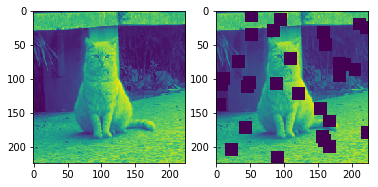

In [4]:
# 获取图像
img = Image.open('cat.jpg')
tr = T.Compose([
    # 将图像统一为224×224大小
    T.Resize((224, 224)),
    # 图片转换为Tensor格式
    T.ToTensor()
])
x = tr(img)
# 设定参数进行dropblock操作
drop_block = DropBlock(block_size=19, keep_prob=0.85)
x_drop = drop_block(x)
# 绘制原始图像第一个通道dropblock操作前后的对比图
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x[0,:,:].squeeze().numpy())
axs[1].imshow(x_drop[0,:,:].squeeze().numpy())

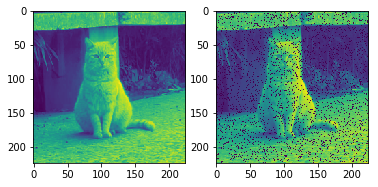

In [5]:
# 获取图像
img = Image.open('cat.jpg')
tr = T.Compose([
    # 将图像统一为224×224大小
    T.Resize((224, 224)),
    # 图片转换为Tensor格式
    T.ToTensor()
])
x = tr(img)
# 设定参数进行dropblock操作
drop_block = DropBlock(block_size=1, keep_prob=0.9)
x_drop = drop_block(x)
# 绘制原始图像第一个通道dropblock操作前后的对比图
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x[0,:,:].squeeze().numpy())
axs[1].imshow(x_drop[0,:,:].squeeze().numpy())